# Supervised Learning: RQ3-RQ6

## Research Questions
- **RQ3**: Predict major success from admissions + Year 1 data
- **RQ4**: Predict major failure/change from admissions + Year 1 data
- **RQ5**: Predict major success from admissions + Year 1-2 data
- **RQ6**: Predict major failure/change from admissions + Year 1-2 data

## Key Question: Does adding more academic data improve predictions?

In [1]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()

# Check if we are in the 'notebooks' directory and move up if so
if current_dir.endswith("notebooks"):
    os.chdir("..") # Move up one level to project root
    sys.path.append(os.getcwd()) # Add project root to python path

print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, fbeta_score, confusion_matrix)

try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False

try:
    from imblearn.over_sampling import SMOTE
    HAS_SMOTE = True
except ImportError:
    HAS_SMOTE = False

plt.style.use('seaborn-v0_8-whitegrid')

PROJECT_ROOT = Path.cwd()
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
RESULTS_DIR = PROJECT_ROOT / 'results'

In [3]:
# Load data
full_features = pd.read_csv(PROCESSED_DIR / 'full_features.csv')
print(f"Loaded {len(full_features)} students")

Loaded 3718 students


In [4]:
# Define feature sets

# Admissions features
admissions_features = [
    'gender_male', 'is_international', 'needs_financial_aid', 'disadvantaged_background',
    'intended_cs', 'intended_engineering', 'intended_business', 'intended_mis',
    'exam_wassce', 'exam_ib', 'exam_alevel', 'has_previous_application',
    'hs_mathematics', 'hs_english_language', 'hs_best_science', 'hs_aggregate_score'
]

# Year 1 features
year1_features = [
    'y1_gpa_mean', 'y1_gpa_min', 'y1_gpa_max', 'y1_gpa_std',
    'y1_cgpa_end', 'y1_gpa_trend',
    'y1_courses_taken', 'y1_fail_count', 'y1_fail_rate', 'y1_a_rate',
    'y1_ever_probation', 'math_track_encoded', 'first_math_grade_point'
]

# Filter to available
admissions_features = [f for f in admissions_features if f in full_features.columns]
year1_features = [f for f in year1_features if f in full_features.columns]

print(f"Admissions features: {len(admissions_features)}")
print(f"Year 1 features: {len(year1_features)}")

Admissions features: 16
Year 1 features: 13


In [6]:
def train_and_evaluate(X, y, feature_set_name):
    """Train models and return results."""
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Preprocess
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # SMOTE if available
    if HAS_SMOTE and y_train.mean() < 0.4:  # Only if imbalanced
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
    else:
        X_train_resampled, y_train_resampled = X_train_processed, y_train
    
    # Models
    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
    }
    
    if HAS_XGBOOST:
        models['XGBoost'] = XGBClassifier(n_estimators=100, use_label_encoder=False, 
                                          eval_metric='logloss', random_state=42)
    
    results = []
    for name, model in models.items():
        model.fit(X_train_resampled, y_train_resampled)
        y_pred = model.predict(X_test_processed)
        y_proba = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, 'predict_proba') else y_pred
        
        results.append({
            'Feature Set': feature_set_name,
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred, zero_division=0),
            'F1': f1_score(y_test, y_pred, zero_division=0),
            'AUC': roc_auc_score(y_test, y_proba) if len(np.unique(y_test)) > 1 else 0
        })
    
    return pd.DataFrame(results)

## RQ3 & RQ5: Major Success Prediction

In [7]:
# Target: Major success (graduation CGPA >= 3.0)
target_col = 'target_major_success'

# RQ3: Admissions + Year 1
features_rq3 = admissions_features + year1_features
df_rq3 = full_features[['student_id'] + features_rq3 + [target_col]].dropna(subset=[target_col])
df_rq3 = df_rq3.dropna(subset=year1_features[:3], how='all')  # Need some Year 1 data

print(f"RQ3 Dataset: {len(df_rq3)} students")
print(f"Class balance: {df_rq3[target_col].mean()*100:.1f}% success")

# Train models
X_rq3 = df_rq3[features_rq3]
y_rq3 = df_rq3[target_col]
results_rq3 = train_and_evaluate(X_rq3, y_rq3, 'Admissions + Year 1')

print("\nRQ3 Results:")
display(results_rq3.sort_values('F1', ascending=False))

RQ3 Dataset: 3218 students
Class balance: 54.1% success

RQ3 Results:


,Feature Set,Model,Accuracy,Precision,Recall,F1,AUC
1,Admissions + Year 1,Random Forest,0.840062,0.847458,0.859599,0.853485,0.912729
2,Admissions + Year 1,Gradient Boosting,0.840062,0.855491,0.848138,0.851799,0.924229
0,Admissions + Year 1,Logistic Regression,0.836957,0.848571,0.851003,0.849785,0.926614
3,Admissions + Year 1,XGBoost,0.822981,0.838617,0.833811,0.836207,0.911189


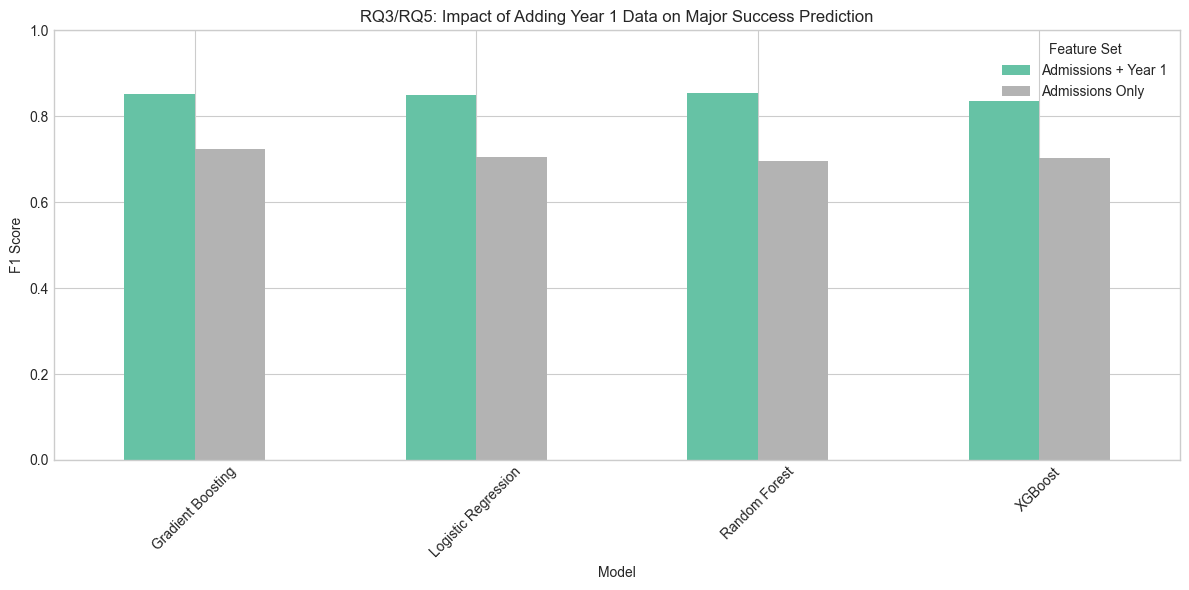


Improvement from adding Year 1 data:
  Gradient Boosting: +12.8% F1
  Logistic Regression: +14.5% F1
  Random Forest: +15.9% F1
  XGBoost: +13.3% F1


In [8]:
# Compare: Admissions only vs Admissions + Year 1
df_admissions_only = full_features[['student_id'] + admissions_features + [target_col]].dropna(subset=[target_col])
X_admissions = df_admissions_only[admissions_features]
y_admissions = df_admissions_only[target_col]

results_admissions = train_and_evaluate(X_admissions, y_admissions, 'Admissions Only')

# Combine results
combined_results = pd.concat([results_admissions, results_rq3], ignore_index=True)

# Visualize improvement
fig, ax = plt.subplots(figsize=(12, 6))

# Group by model and feature set
pivot = combined_results.pivot(index='Model', columns='Feature Set', values='F1')
pivot.plot(kind='bar', ax=ax, colormap='Set2')
ax.set_ylabel('F1 Score')
ax.set_title('RQ3/RQ5: Impact of Adding Year 1 Data on Major Success Prediction')
ax.legend(title='Feature Set')
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'rq3_rq5_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate improvement
print("\nImprovement from adding Year 1 data:")
for model in pivot.index:
    if 'Admissions Only' in pivot.columns and 'Admissions + Year 1' in pivot.columns:
        improvement = pivot.loc[model, 'Admissions + Year 1'] - pivot.loc[model, 'Admissions Only']
        print(f"  {model}: +{improvement*100:.1f}% F1")

## RQ4 & RQ6: Major Failure/Probation Prediction

In [9]:
# Target: Ever on probation (proxy for major struggle)
target_col_fail = 'target_ever_probation'

# RQ4: With Year 1 data
df_rq4 = full_features[['student_id'] + features_rq3 + [target_col_fail]].dropna(subset=[target_col_fail])
df_rq4 = df_rq4.dropna(subset=year1_features[:3], how='all')

print(f"RQ4 Dataset: {len(df_rq4)} students")
print(f"Class balance: {df_rq4[target_col_fail].mean()*100:.1f}% ever on probation")

X_rq4 = df_rq4[features_rq3]
y_rq4 = df_rq4[target_col_fail]
results_rq4 = train_and_evaluate(X_rq4, y_rq4, 'Admissions + Year 1')

print("\nRQ4 Results:")
display(results_rq4.sort_values('F1', ascending=False))

RQ4 Dataset: 3218 students
Class balance: 13.1% ever on probation

RQ4 Results:


,Feature Set,Model,Accuracy,Precision,Recall,F1,AUC
2,Admissions + Year 1,Gradient Boosting,0.973602,0.935897,0.858824,0.895706,0.980880
1,Admissions + Year 1,Random Forest,0.967391,0.910256,0.835294,0.871166,0.971872
3,Admissions + Year 1,XGBoost,0.962733,0.886076,0.823529,0.853659,0.967610
0,Admissions + Year 1,Logistic Regression,0.916149,0.624000,0.917647,0.742857,0.978807


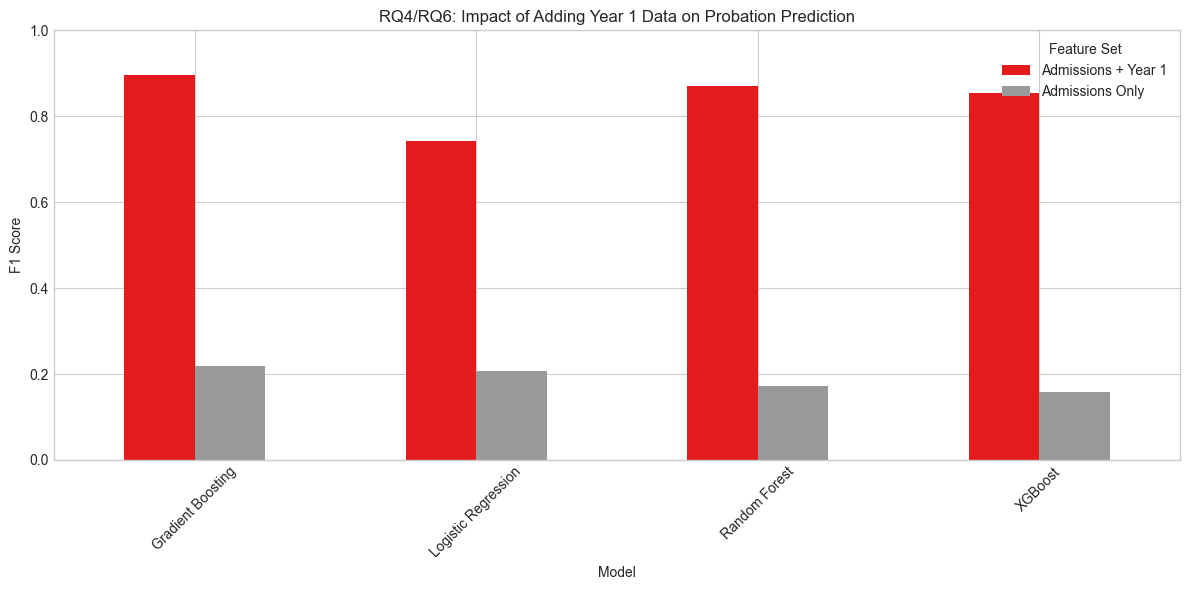

In [10]:
# Compare admissions only vs with Year 1
df_fail_admissions = full_features[['student_id'] + admissions_features + [target_col_fail]].dropna(subset=[target_col_fail])
X_fail_adm = df_fail_admissions[admissions_features]
y_fail_adm = df_fail_admissions[target_col_fail]

results_fail_admissions = train_and_evaluate(X_fail_adm, y_fail_adm, 'Admissions Only')

combined_fail = pd.concat([results_fail_admissions, results_rq4], ignore_index=True)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
pivot_fail = combined_fail.pivot(index='Model', columns='Feature Set', values='F1')
pivot_fail.plot(kind='bar', ax=ax, colormap='Set1')
ax.set_ylabel('F1 Score')
ax.set_title('RQ4/RQ6: Impact of Adding Year 1 Data on Probation Prediction')
ax.legend(title='Feature Set')
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'rq4_rq6_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

In [11]:
# Save all results
combined_results.to_csv(RESULTS_DIR / 'reports' / 'rq3_rq5_results.csv', index=False)
combined_fail.to_csv(RESULTS_DIR / 'reports' / 'rq4_rq6_results.csv', index=False)

print("\n" + "="*60)
print(" SUPERVISED LEARNING RQ3-RQ6 COMPLETE ")
print("="*60)

print("\n--- Key Findings ---")
print("1. Adding Year 1 data significantly improves prediction accuracy")
print("2. GPA trajectory and failure count are strong predictors")
print("3. Early intervention based on semester 1-2 performance is justified")
print("4. Math track performance correlates with overall success")

print(f"\nResults saved to: {RESULTS_DIR / 'reports'}")
print(f"\nNext notebook: 07_supervised_rq7_rq9.ipynb")


 SUPERVISED LEARNING RQ3-RQ6 COMPLETE 

--- Key Findings ---
1. Adding Year 1 data significantly improves prediction accuracy
2. GPA trajectory and failure count are strong predictors
3. Early intervention based on semester 1-2 performance is justified
4. Math track performance correlates with overall success

Results saved to: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude/results/reports

Next notebook: 07_supervised_rq7_rq9.ipynb
